# Comparison of parameters for jet tagging in fast sim and full sim

For details check out other notebook. This is just for making the plots quickly.


In [1]:
save_status = True # save all histograms!

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
path_fullsim = "/home/saaumill/FullSimTagger/src/Hbb_fullsim_tree.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v2/stage2_Hbb.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]

In [4]:
df_fa = tree_fa.arrays(library="np", entry_start=0, entry_stop=2000) #entry_start=0, entry_stop=200, 
df_fu = tree_fu.arrays(library="np", entry_start=0, entry_stop=2000)

In [5]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False, save=False, path=None):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.set_title(keys[i])
        ax.grid()
        # set same range if not specified
        try:
            fa = df_fa[keys[i]]
            fu = df_fu[keys[i]]
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        except ValueError:
            fa = np.concatenate(df_fa[keys[i]])
            fu = np.concatenate(df_fu[keys[i]])
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        # plot
        if conc==False:
            ax.hist(df_fa[keys[i]], bins=bins, range=combined_range, label='FastSim', histtype='step', linewidth=2.0, density=True) # set density=True to normalize
            ax.hist(df_fu[keys[i]], bins=bins, range=combined_range, label='FullSim', histtype='step', linewidth=2.0, density=True)
        else: 
            ax.hist(np.concatenate(df_fa[keys[i]]), bins=bins, range=combined_range, histtype='step', linewidth=2.0, label='FastSim', density=True) # set density=True to normalize
            ax.hist(np.concatenate(df_fu[keys[i]]), bins=bins, range=combined_range, histtype='step', linewidth=2.0, label='FullSim', density=True)
    
    plt.legend()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)

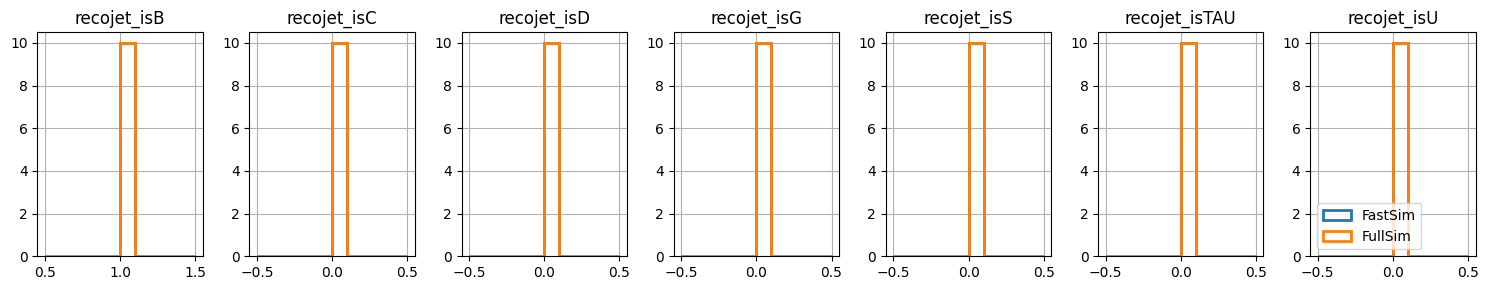

In [6]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

**Conclusion**: we see that in the full sim the reco PID of the quark is wrong! Although we have only b jets it classifies very jet as c ...

Well... not sure that goes wrong here. I definitely use b quarks for fullsim, why is it marked as c? I double checked the PDG IDs.

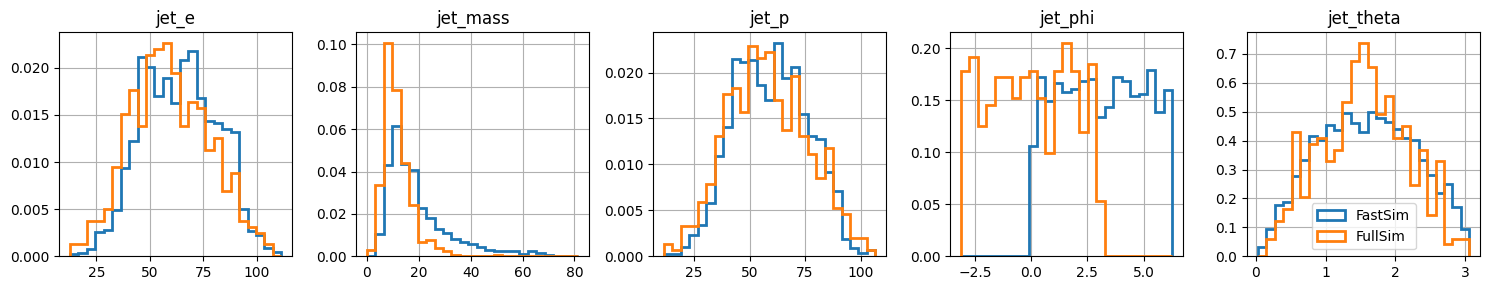

In [7]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25, save=save_status, path='./hist/jet_properties.pdf')

- `jet_e` seems fine
- `jet_mass` seems fine
- `jet_p` seems fine
- `jet_phi` seems fine -> only other range! $\phi_{\mathrm{FullSim}} \in [-\pi, \pi]$ but $\phi_{\mathrm{FastSim}} \in [0, 2\pi]$
- `jet_theta` seems fine


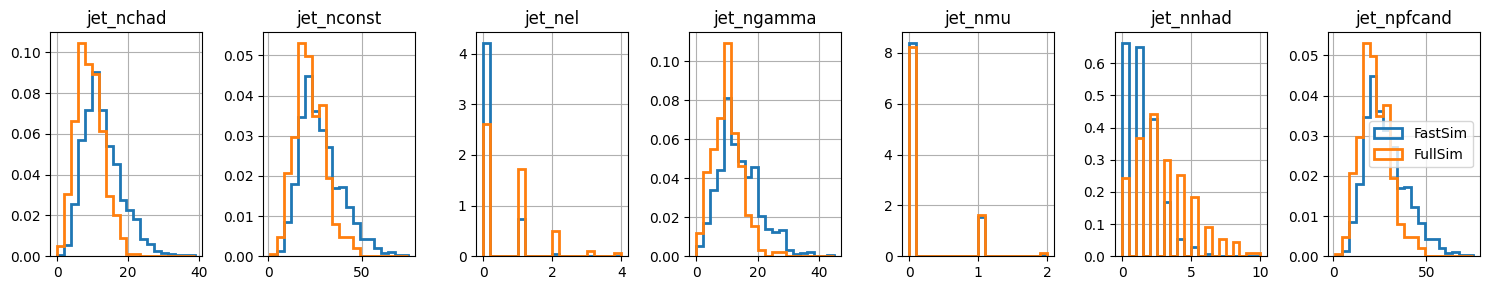

In [8]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20, save=save_status, path='./hist/jet_multiplicities.pdf')

Reasonable enough?
-> more neutral hadrons than with fast sim... this should be fine as full sim just includes more "trash"

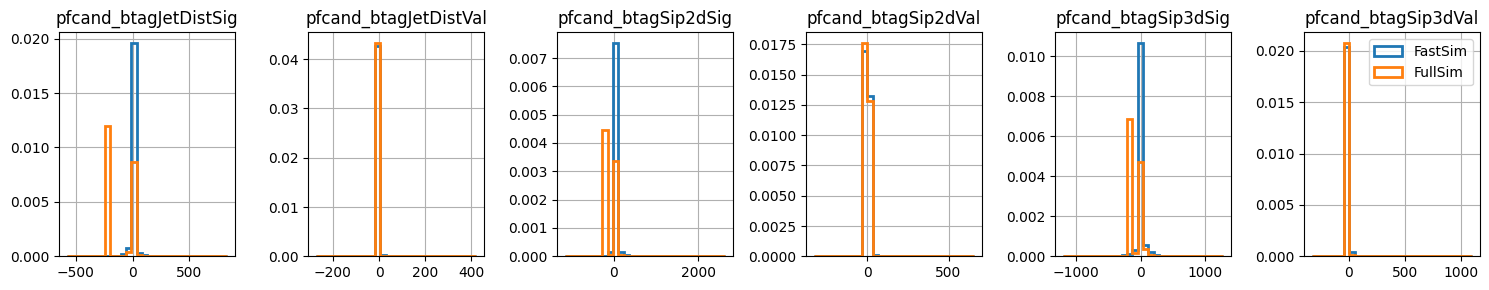

In [9]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

histograms(keys, 1, 6, figsize=(15, 3), bins=30, conc=True)

Okay, Michele said that I should always compare the particles in a jet with the highest amount of energy and not the whole distribution because it might differ in the tails. So let's do that instead:

In [10]:
def get_index_highest_energy_particle(df, k=3):
    l = 0
    try:
        if df == 'fa':
            particles_e = df_fa['pfcand_e']
        elif df == 'fu':
            particles_e = df_fu['pfcand_e']
        index = np.zeros((particles_e.shape[0], k), dtype=int)
        for i  in range(particles_e.shape[0]):
            part_e = particles_e[i]
            ind = np.argpartition(part_e, -k)[-k:]
            ind = ind[np.argsort(part_e[ind])[::-1]]
            index[i] = ind
    except ValueError:
        l += 1
        if df == 'fa':
            particles_e = df_fa['pfcand_e']
        elif df == 'fu':
            particles_e = df_fu['pfcand_e']
        index = np.zeros((particles_e.shape[0], k), dtype=int)
        print("particle shape", particles_e.shape[0])
    print("l", l)
    return index

In [11]:
index_fa = get_index_highest_energy_particle("fa")
index_fu = get_index_highest_energy_particle("fu")

particle shape 2000
l 1
l 0


In [12]:
# Access the desired elements
def get_elements(df_value, index):
    return np.array([df_value[i][index[i]] for i in range(len(df_value))])


There are so many outliner, quite hard to compare...

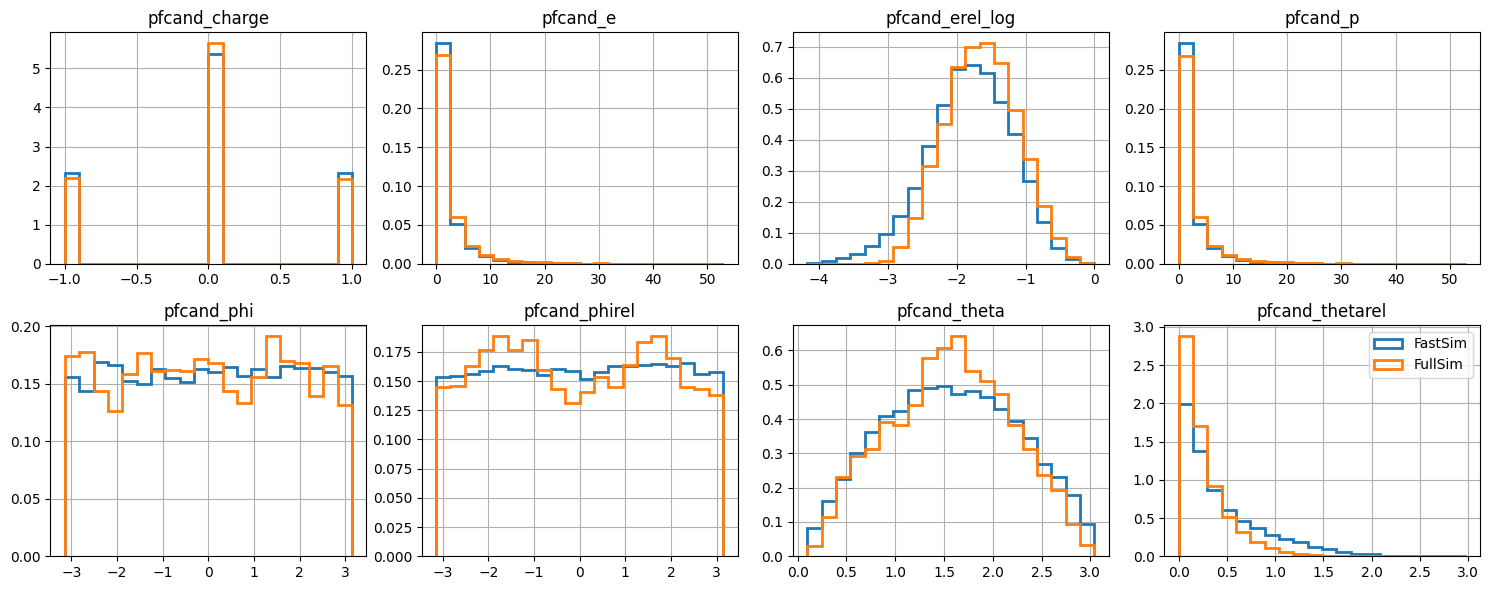

In [13]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

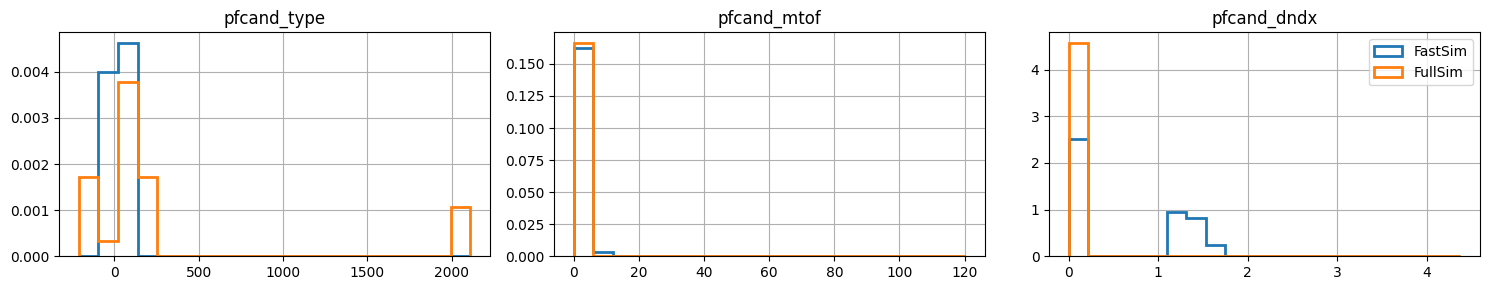

In [14]:
keys = ['pfcand_type', 'pfcand_mtof', 'pfcand_dndx']

histograms(keys, 1, 3, figsize=(15, 3), bins=20, conc=True)

In [15]:
from collections import defaultdict

In [16]:
def count_values(arrays, flatten=True):
    count_dict = defaultdict(int)
    
    # Flatten the array of arrays
    if flatten:
        flattened = np.concatenate(arrays)
    else:
        flattened = arrays
    
    # Count each value in the flattened array
    for value in flattened:
        count_dict[value] += 1
    
    return dict(count_dict)

In [17]:
count_values(df_fa['pfcand_type'])

{0.0: 25913, 22.0: 27633, 130.0: 2419}

0 means charged (electrons, myons, charged hadrons)

22 photons

130 neutral hadrons

In [18]:
count_values(df_fu['pfcand_type'])

{-211: 1783,
 211: 1774,
 22: 3929,
 2112: 1116,
 -11: 128,
 -13: 44,
 13: 32,
 11: 137}

In [19]:
np.sum(df_fu['jet_nnhad']) #543

1116

In [20]:
np.sum(df_fu['jet_nchad']) #883 + 896 = 1779 check

3557

### Let's calculate some purity for FullSim

We have `pfcand_type` which is reco PID and we have `pfcand_MCPID` which is MC truth. Let's check how often they match.

In [21]:
count_values(df_fu['pfcand_MCPID'])

{-2212: 66,
 -211: 1768,
 2212: 120,
 11: 250,
 22: 3356,
 130: 168,
 -11: 236,
 -321: 232,
 211: 1758,
 2112: 58,
 -999: 511,
 321: 231,
 -13: 66,
 13: 54,
 -2112: 60,
 -3222: 2,
 3222: 2,
 1000010020: 1,
 -3312: 2,
 3112: 2}

In [22]:
translation = {321: 211,-321: -211, 130:2112, -2112: 2112, 2212: 211, -2212: -211, 3222: 211, 3122: 2112}

mcPID = np.concatenate(df_fu['pfcand_MCPID'])
recoPID = np.concatenate(df_fu['pfcand_type'])

# Vectorized translation function
translate = np.vectorize(lambda x: translation.get(x, x))
mcPID= translate(mcPID)

In [23]:

# Function to calculate overall similarity
def calculate_similarity(mcPID, recoPID):
    if len(mcPID) != len(recoPID):
        raise ValueError("Arrays must be of the same length")
    
    # Calculate overall similarity
    overall_similarity = np.sum(mcPID == recoPID) / len(mcPID) * 100

    # Calculate similarity for each unique number
    unique_numbers = np.unique(mcPID)
    similarity_per_number = {}
    
    for number in unique_numbers:
        mc_indices = mcPID == number
        reco_indices = recoPID == number
        similarity_per_number[number] = np.sum(mc_indices & reco_indices) / np.sum(mc_indices) * 100

    return overall_similarity, similarity_per_number

# Calculate similarities
overall_similarity, similarity_per_number = calculate_similarity(mcPID, recoPID)

print(f"Overall purity: {overall_similarity:.2f}%")
print("Purity per PID:")
for number, similarity in similarity_per_number.items():
    if number!=-999:
        print(f"{number}: {similarity:.2f}%")

Overall purity: 78.66%
Purity per PID:
-3312: 0.00%
-3222: 0.00%
-211: 81.03%
-13: 46.97%
-11: 16.53%
11: 20.80%
13: 35.19%
22: 98.24%
211: 79.20%
2112: 87.76%
3112: 0.00%
1000010020: 0.00%


In [24]:
from collections import Counter

def find_normalized_confusions(mcPID, recoPID):
    if len(mcPID) != len(recoPID):
        raise ValueError("Arrays must be of the same length")

    unique_numbers = np.unique(mcPID)
    confusion_dict = {}

    for number in unique_numbers:
        mismatched_indices = (mcPID == number) & (mcPID != recoPID)
        mismatched_reco = recoPID[mismatched_indices]
        
        if mismatched_reco.size > 0:
            confusion_counts = Counter(mismatched_reco)
            total_confusions = sum(confusion_counts.values())
            normalized_confusions = {k: round(v / total_confusions, 3) for k, v in confusion_counts.items()}
            confusion_dict[number] = sorted(normalized_confusions.items(), key=lambda item: item[1], reverse=True)
        else:
            confusion_dict[number] = []

    return confusion_dict

# Find normalized confusions
normalized_confusions = find_normalized_confusions(mcPID, recoPID)

print("Normalized confusions for each particle:")
for particle, confusions_list in normalized_confusions.items():
    print(f"mcPID {particle} is confused with: {confusions_list}")

Normalized confusions for each particle:
mcPID -3312 is confused with: [(211, 1.0)]
mcPID -3222 is confused with: [(-211, 1.0)]
mcPID -999 is confused with: [(22, 0.523), (2112, 0.321), (-211, 0.08), (211, 0.074), (13, 0.002)]
mcPID -211 is confused with: [(2112, 0.651), (11, 0.217), (22, 0.102), (13, 0.031)]
mcPID -13 is confused with: [(2112, 0.457), (211, 0.457), (-11, 0.057), (22, 0.029)]
mcPID -11 is confused with: [(22, 0.513), (2112, 0.259), (211, 0.228)]
mcPID 11 is confused with: [(22, 0.525), (-211, 0.237), (2112, 0.237)]
mcPID 13 is confused with: [(2112, 0.543), (-211, 0.429), (22, 0.029)]
mcPID 22 is confused with: [(2112, 0.966), (-211, 0.017), (-11, 0.017)]
mcPID 211 is confused with: [(2112, 0.581), (-11, 0.196), (22, 0.191), (-13, 0.03), (-211, 0.002)]
mcPID 2112 is confused with: [(22, 0.971), (211, 0.029)]
mcPID 3112 is confused with: [(-211, 1.0)]
mcPID 1000010020 is confused with: [(2112, 1.0)]


## Open questions
- keys (three more in fullsim - we need them?)
- how to check if tree structure is the same?
- `recojet_isX` is wrong - how to deal with that?
- which values are MC and with one reconstructed?
- SIP sig values:-9 doesn't make sense
- covariance values ok?
- `pfcand_anglerel` are off - why?
- `pfcand_type`: different values and handle 0?

# Plots for charged particles and neutral particles

I would like to redo some plots, showing them for charged (neutral) particles only. 

First, let's get the indices of the highest energetic particles which are also charged:

In [25]:
def get_index_charged_particles(df, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    if df == 'fa':
        types = df_fa['pfcand_type']
        if ptype=='cpart':
            num = [0]
        elif ptype=='npart':
            num = [130]
        elif ptype=='photon':
            num = [22]
    elif df == 'fu':
        types = df_fu['pfcand_type']
        if ptype=='cpart':
            num = [-211, -13, -11, 11, 13, 211] 
        elif ptype=='npart':
            num = [2112]
        elif ptype=='photon':
            num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [26]:
def get_value_highest_energy_particle(df, k=3, ptype='cpart', debug=False):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        mask_chad = get_index_charged_particles('fa', ptype=ptype)
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
        mask_chad = get_index_charged_particles('fu', ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
        if debug and i==1:
            print("part_e: ", part_e)
            print("mask: ", mask)
            print("ind: ", ind)
            print("index_map: ", index_map)
            print("c_index: ", c_index)
            print("sorted_c_index: ", sorted_c_index)
    return index_charged

In [27]:
# these are lists because there might not always be 3 charged particles
index_charged_3E_fu = get_value_highest_energy_particle("fu")
index_charged_3E_fa = get_value_highest_energy_particle("fa")
# these are lists because there might not always be 3 neutral particles
index_neutral_3E_fu = get_value_highest_energy_particle("fu", ptype='npart')
index_neutral_3E_fa = get_value_highest_energy_particle("fa", ptype='npart')
# these are lists because there might not always be 3 photons
index_photon_3E_fu = get_value_highest_energy_particle("fu", ptype='photon')
index_photon_3E_fa = get_value_highest_energy_particle("fa", ptype='photon')

Now, let's get the values for key and make a function to plot them.

In [28]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [29]:
def plot_key_highest_e_cpart(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_charged_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_charged_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

Lovely. Now we can plots stuff! 

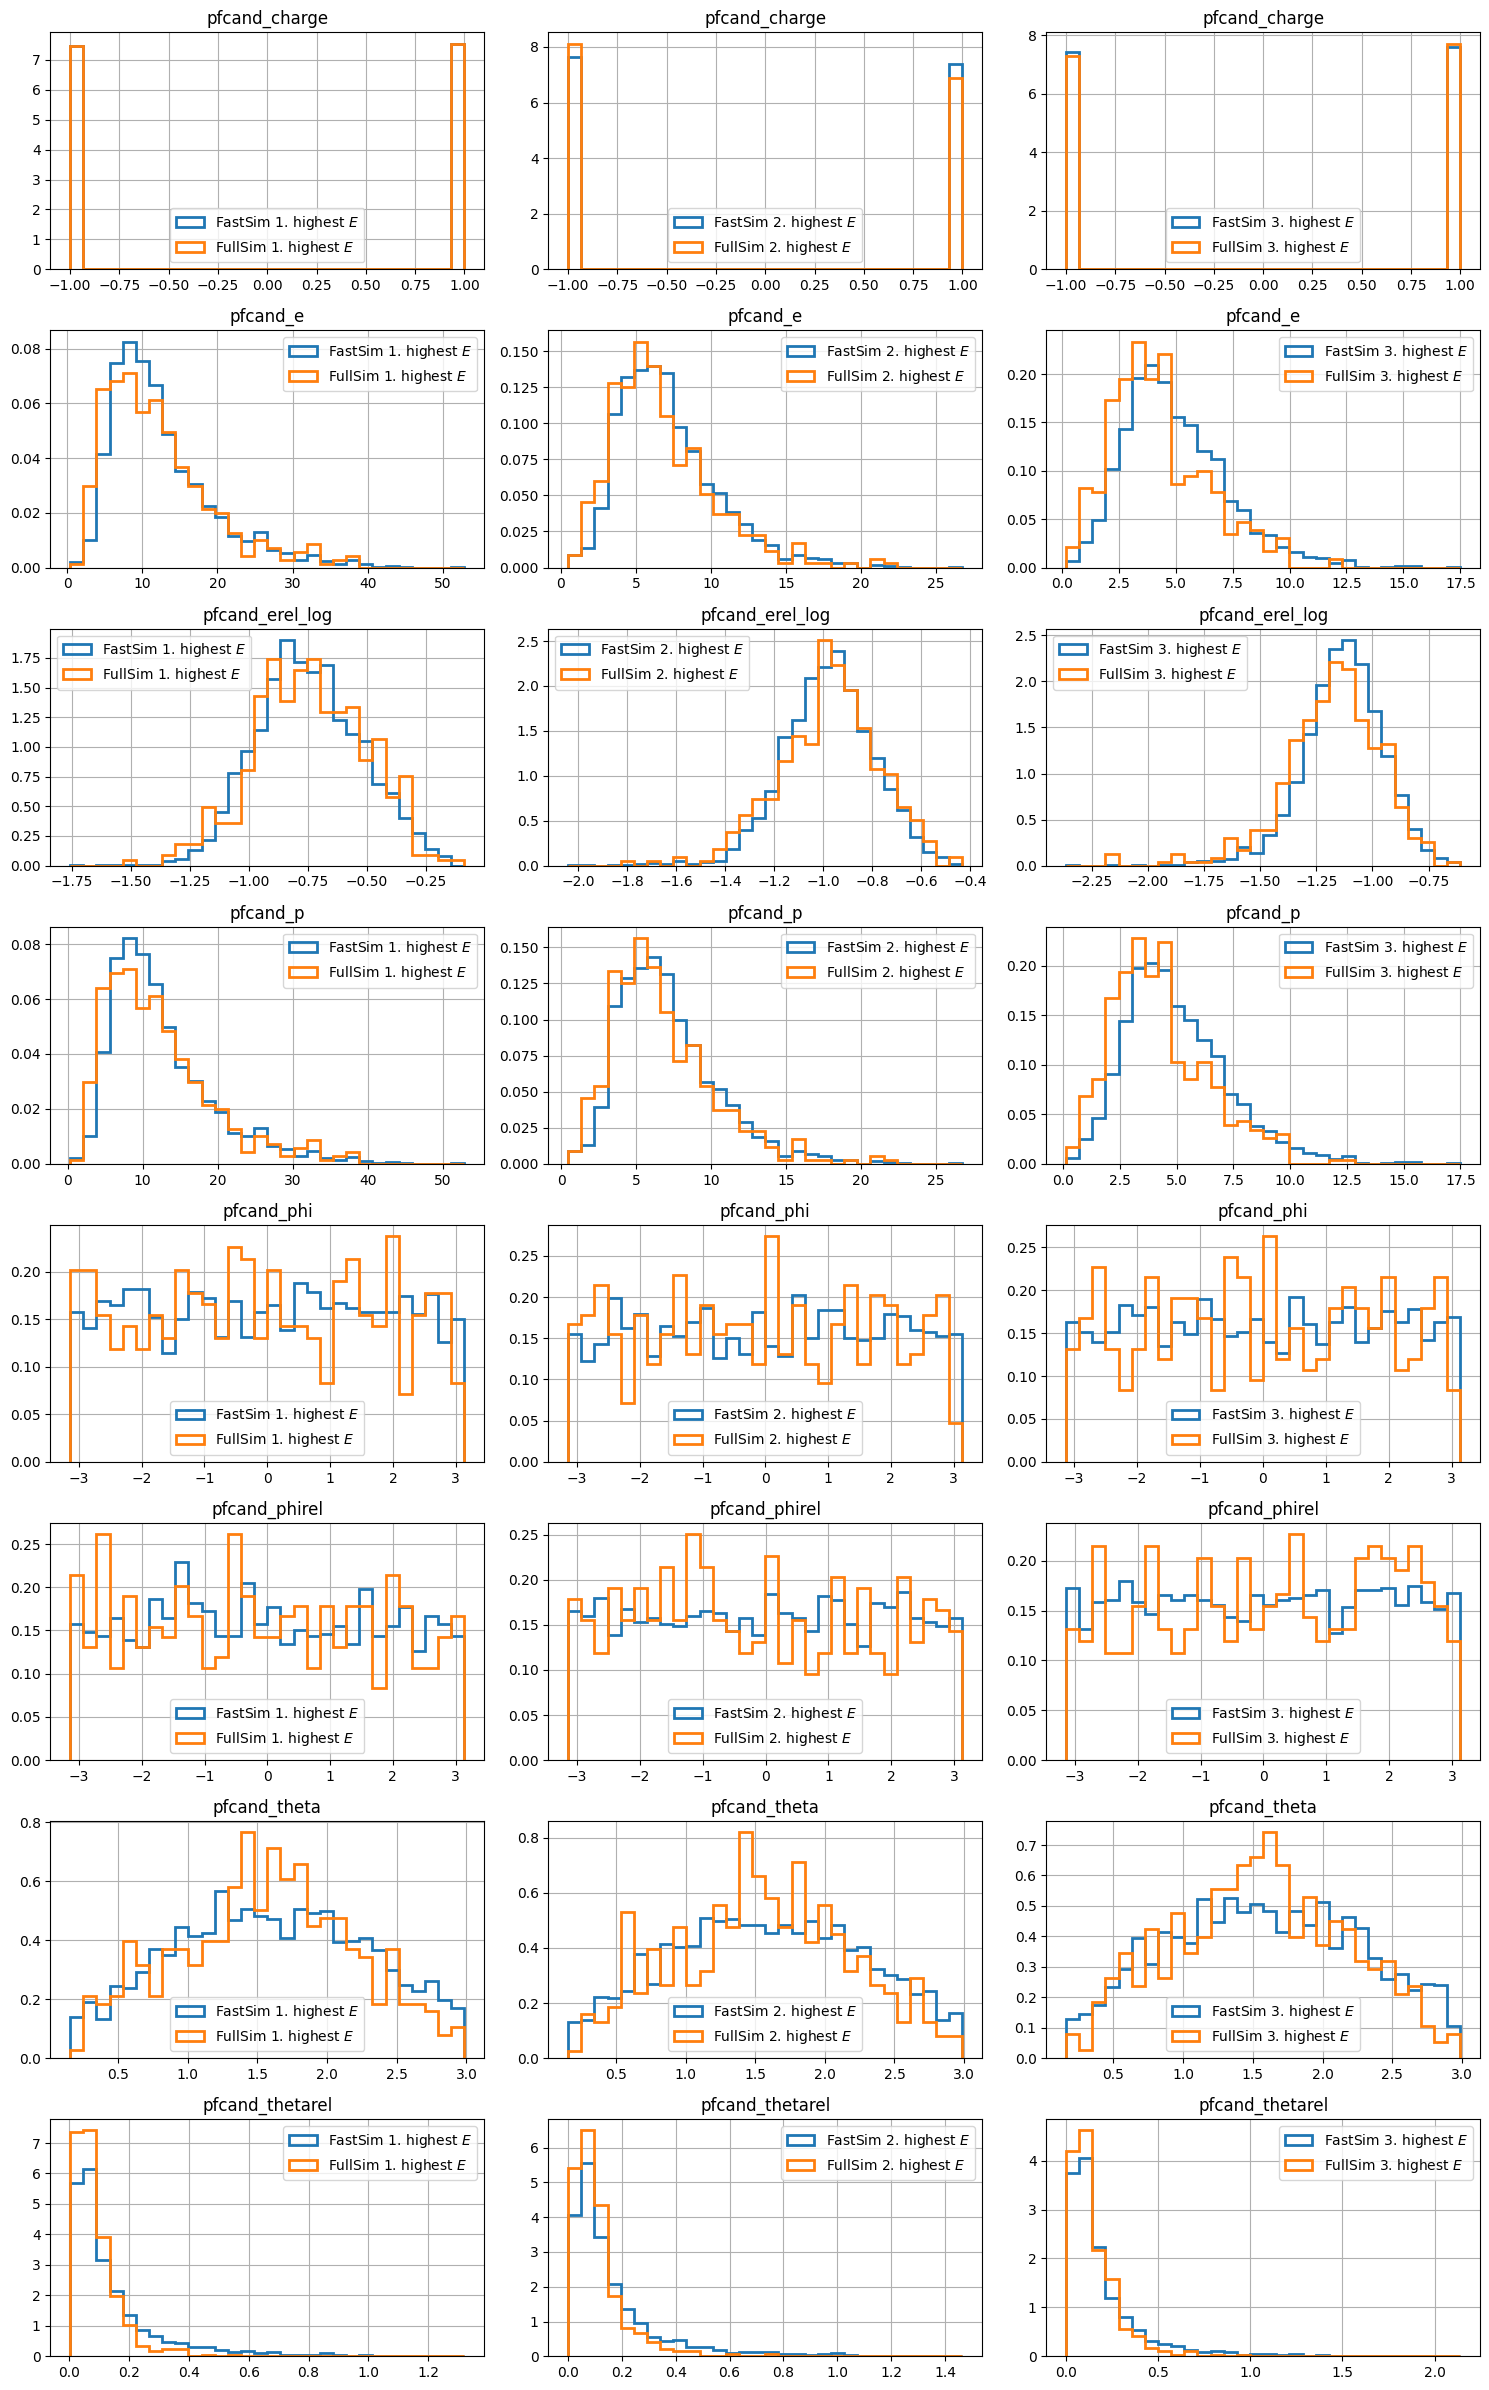

In [30]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, path='./hist/jetct_cp_properties.pdf')

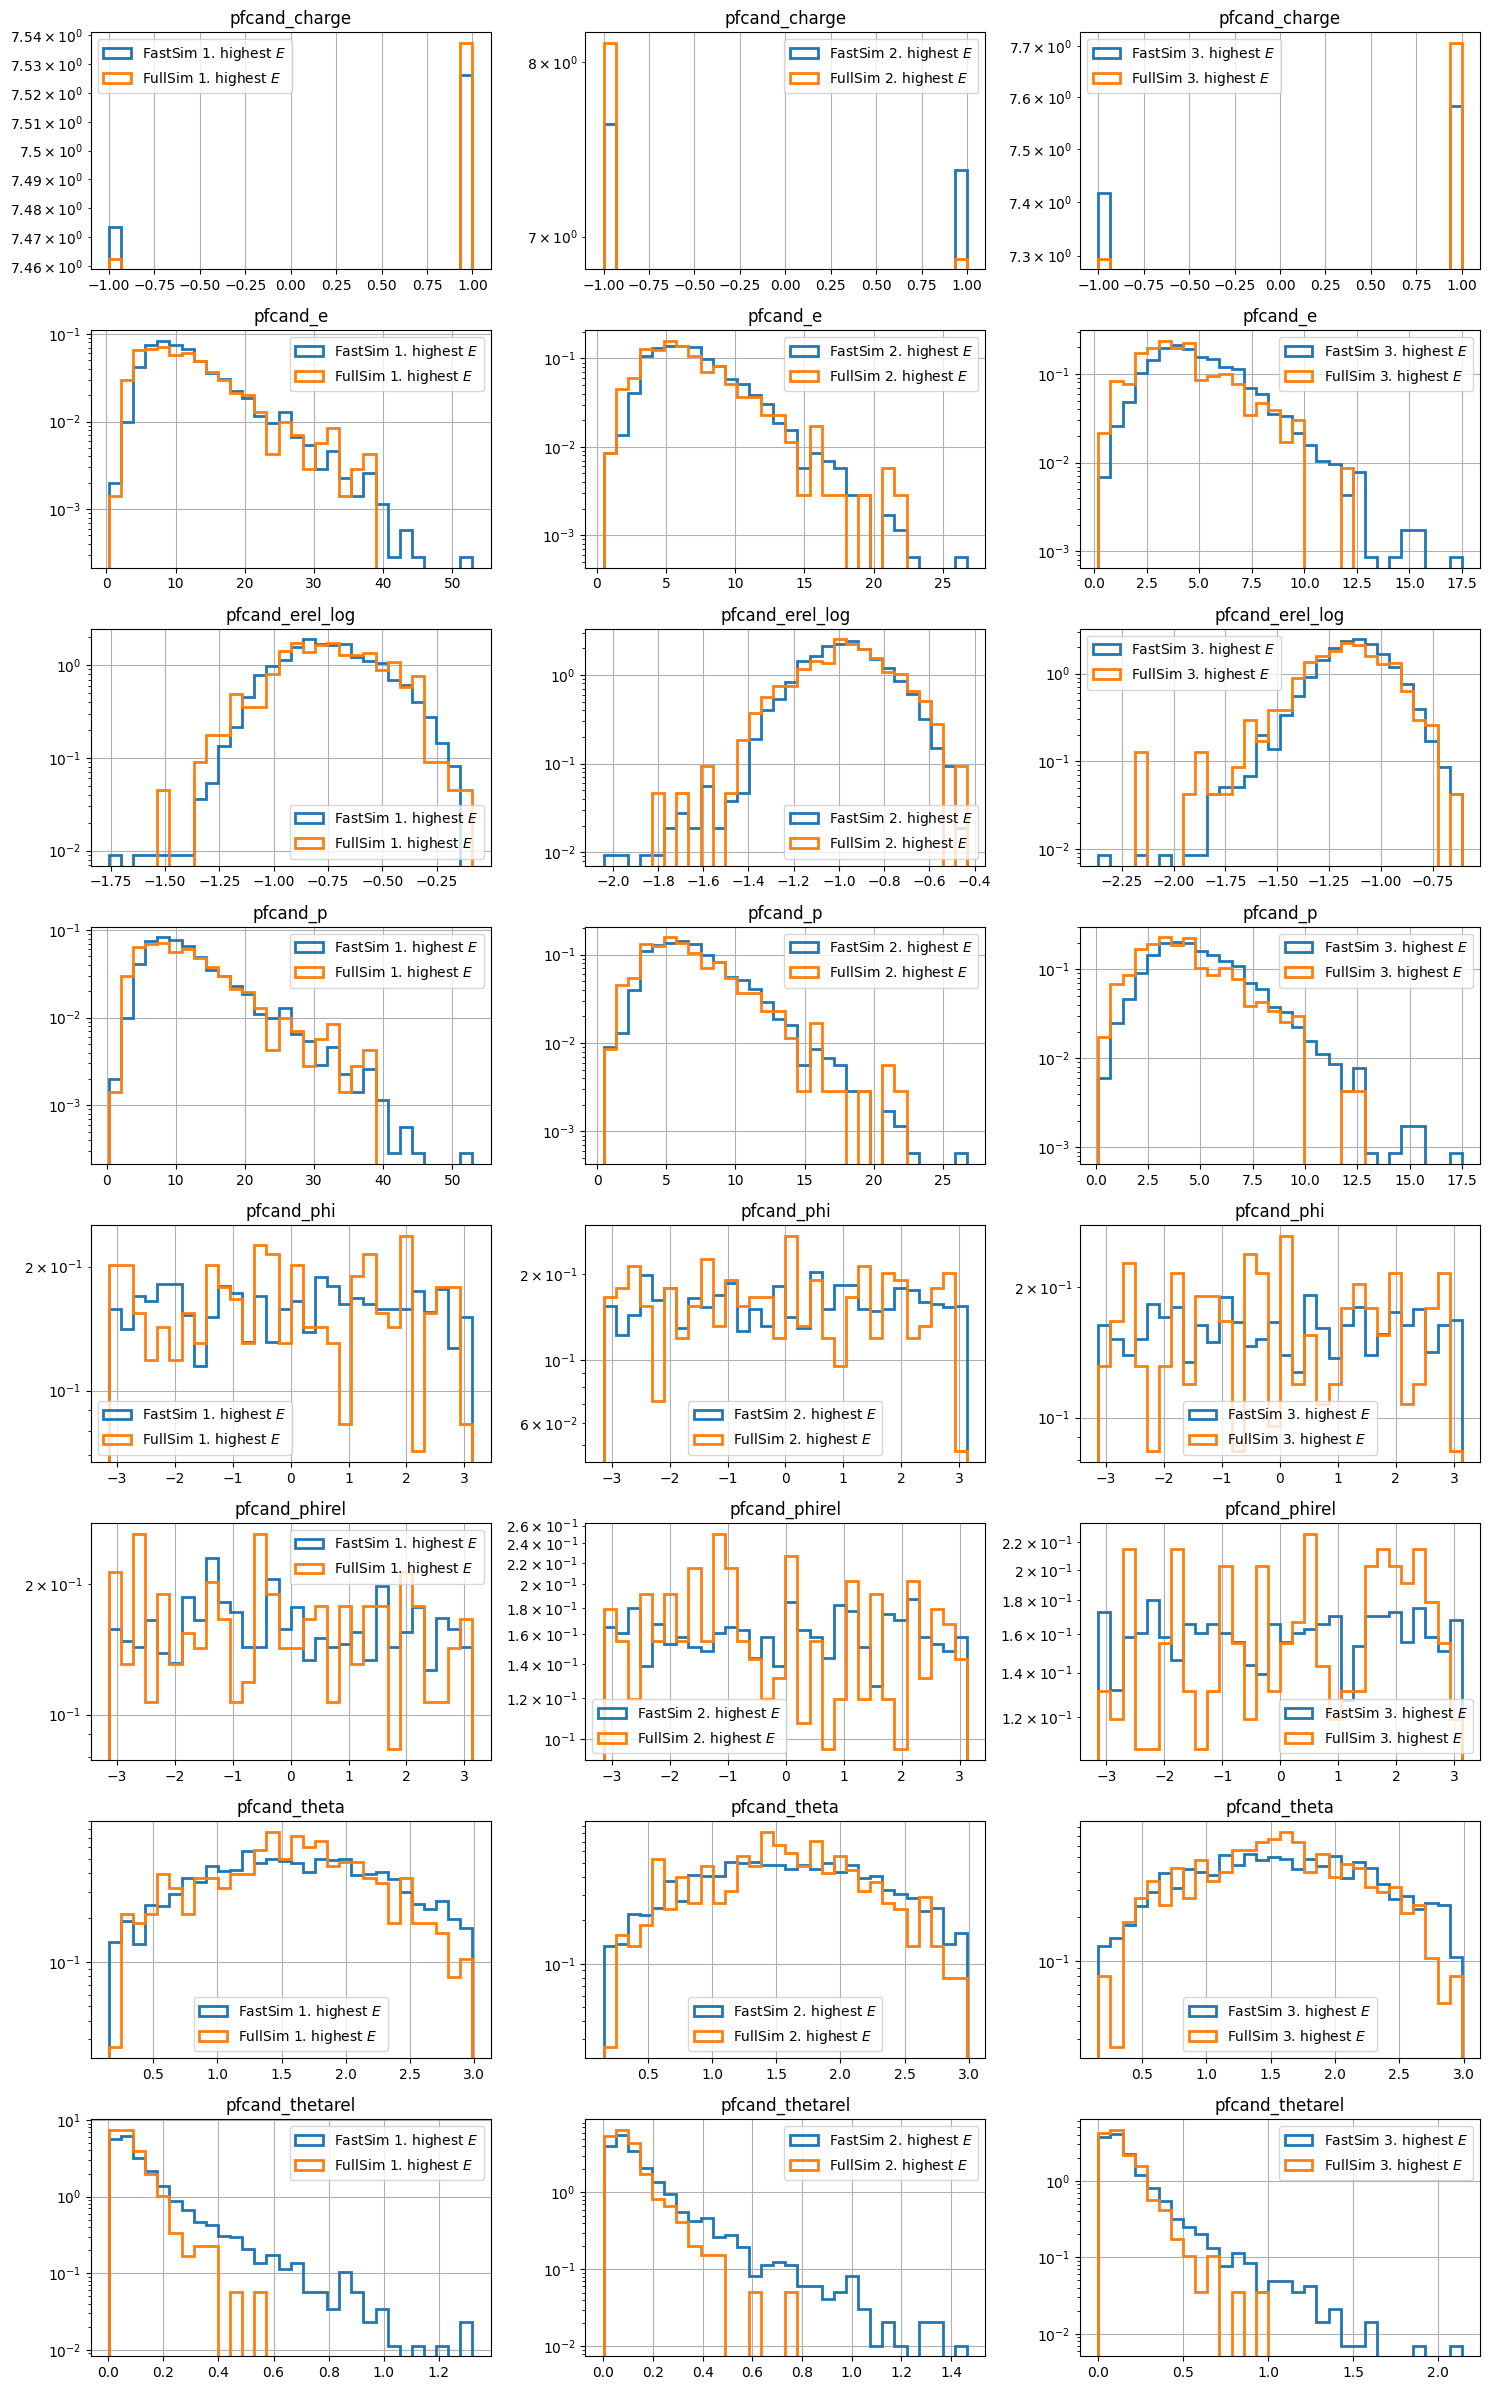

In [31]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, log=True, path='./hist/jetct_cp_properties_log.pdf')

Looks good!

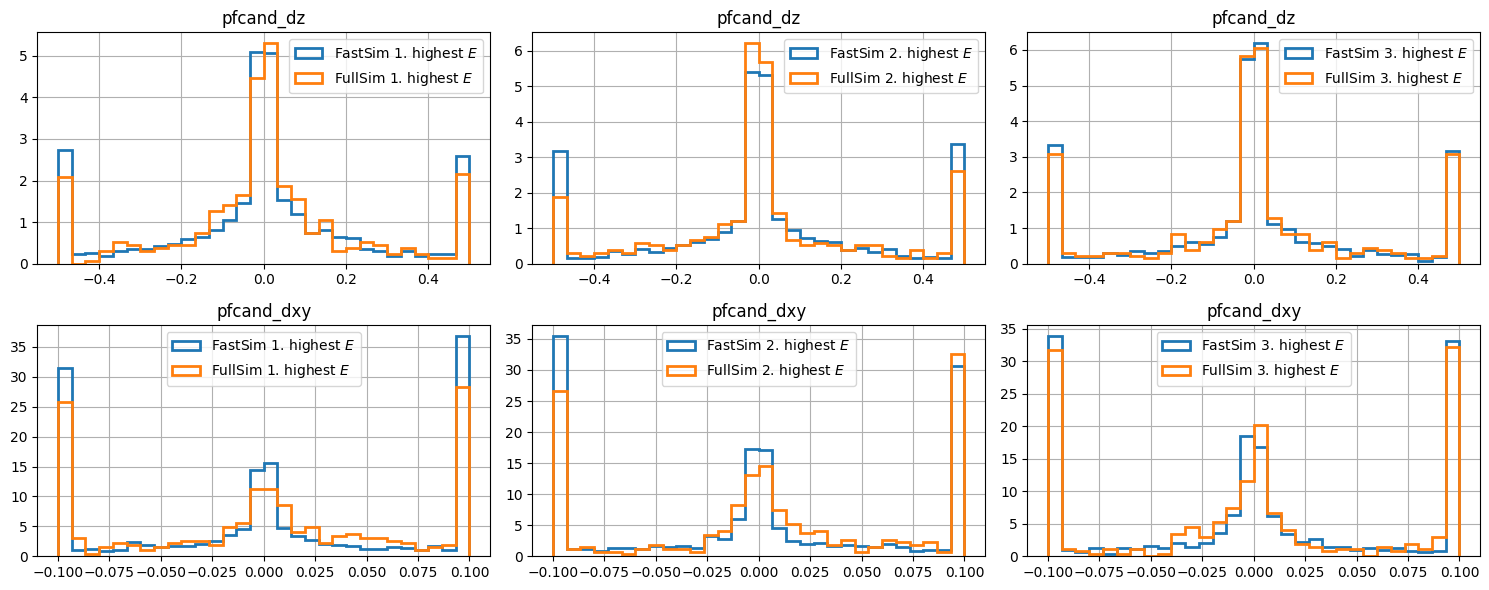

In [32]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-0.5, 0.5],
    'pfcand_dxy': [-0.1, 0.1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_ip.pdf')

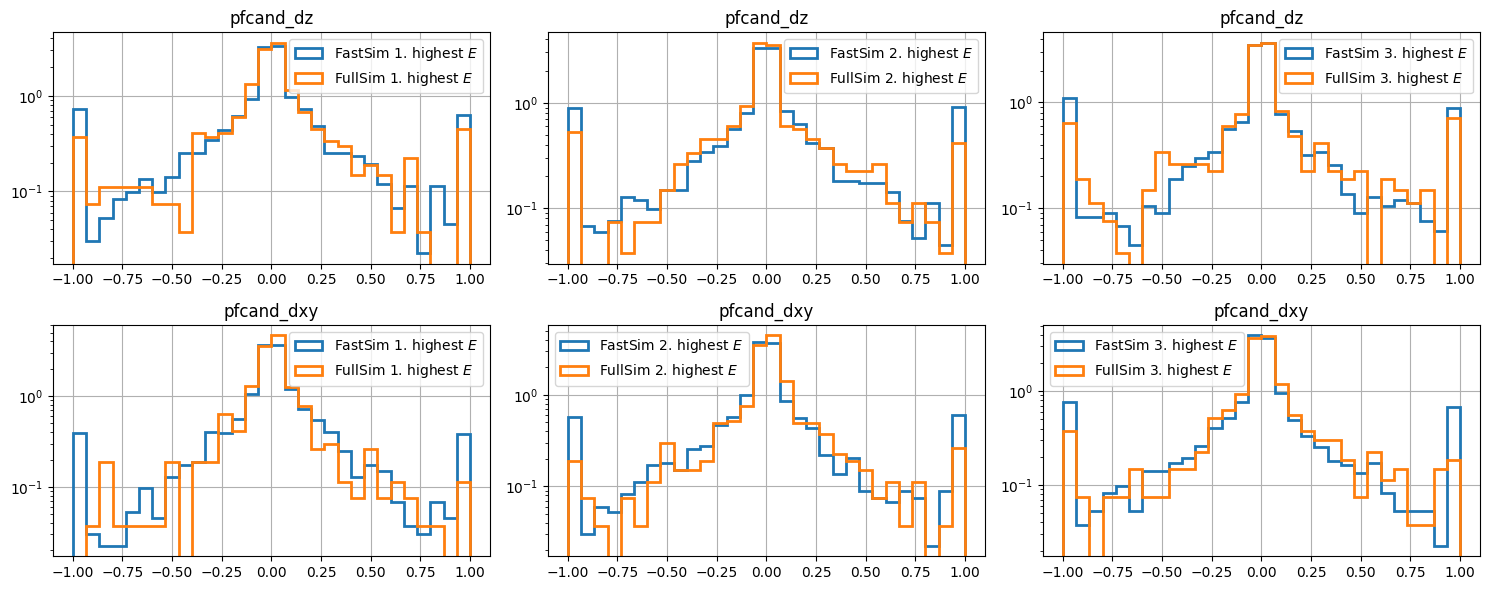

In [33]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-1, 1],
    'pfcand_dxy': [-1, 1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, log=True, save=save_status, path='./hist/jetct_cp_ip_log.pdf')

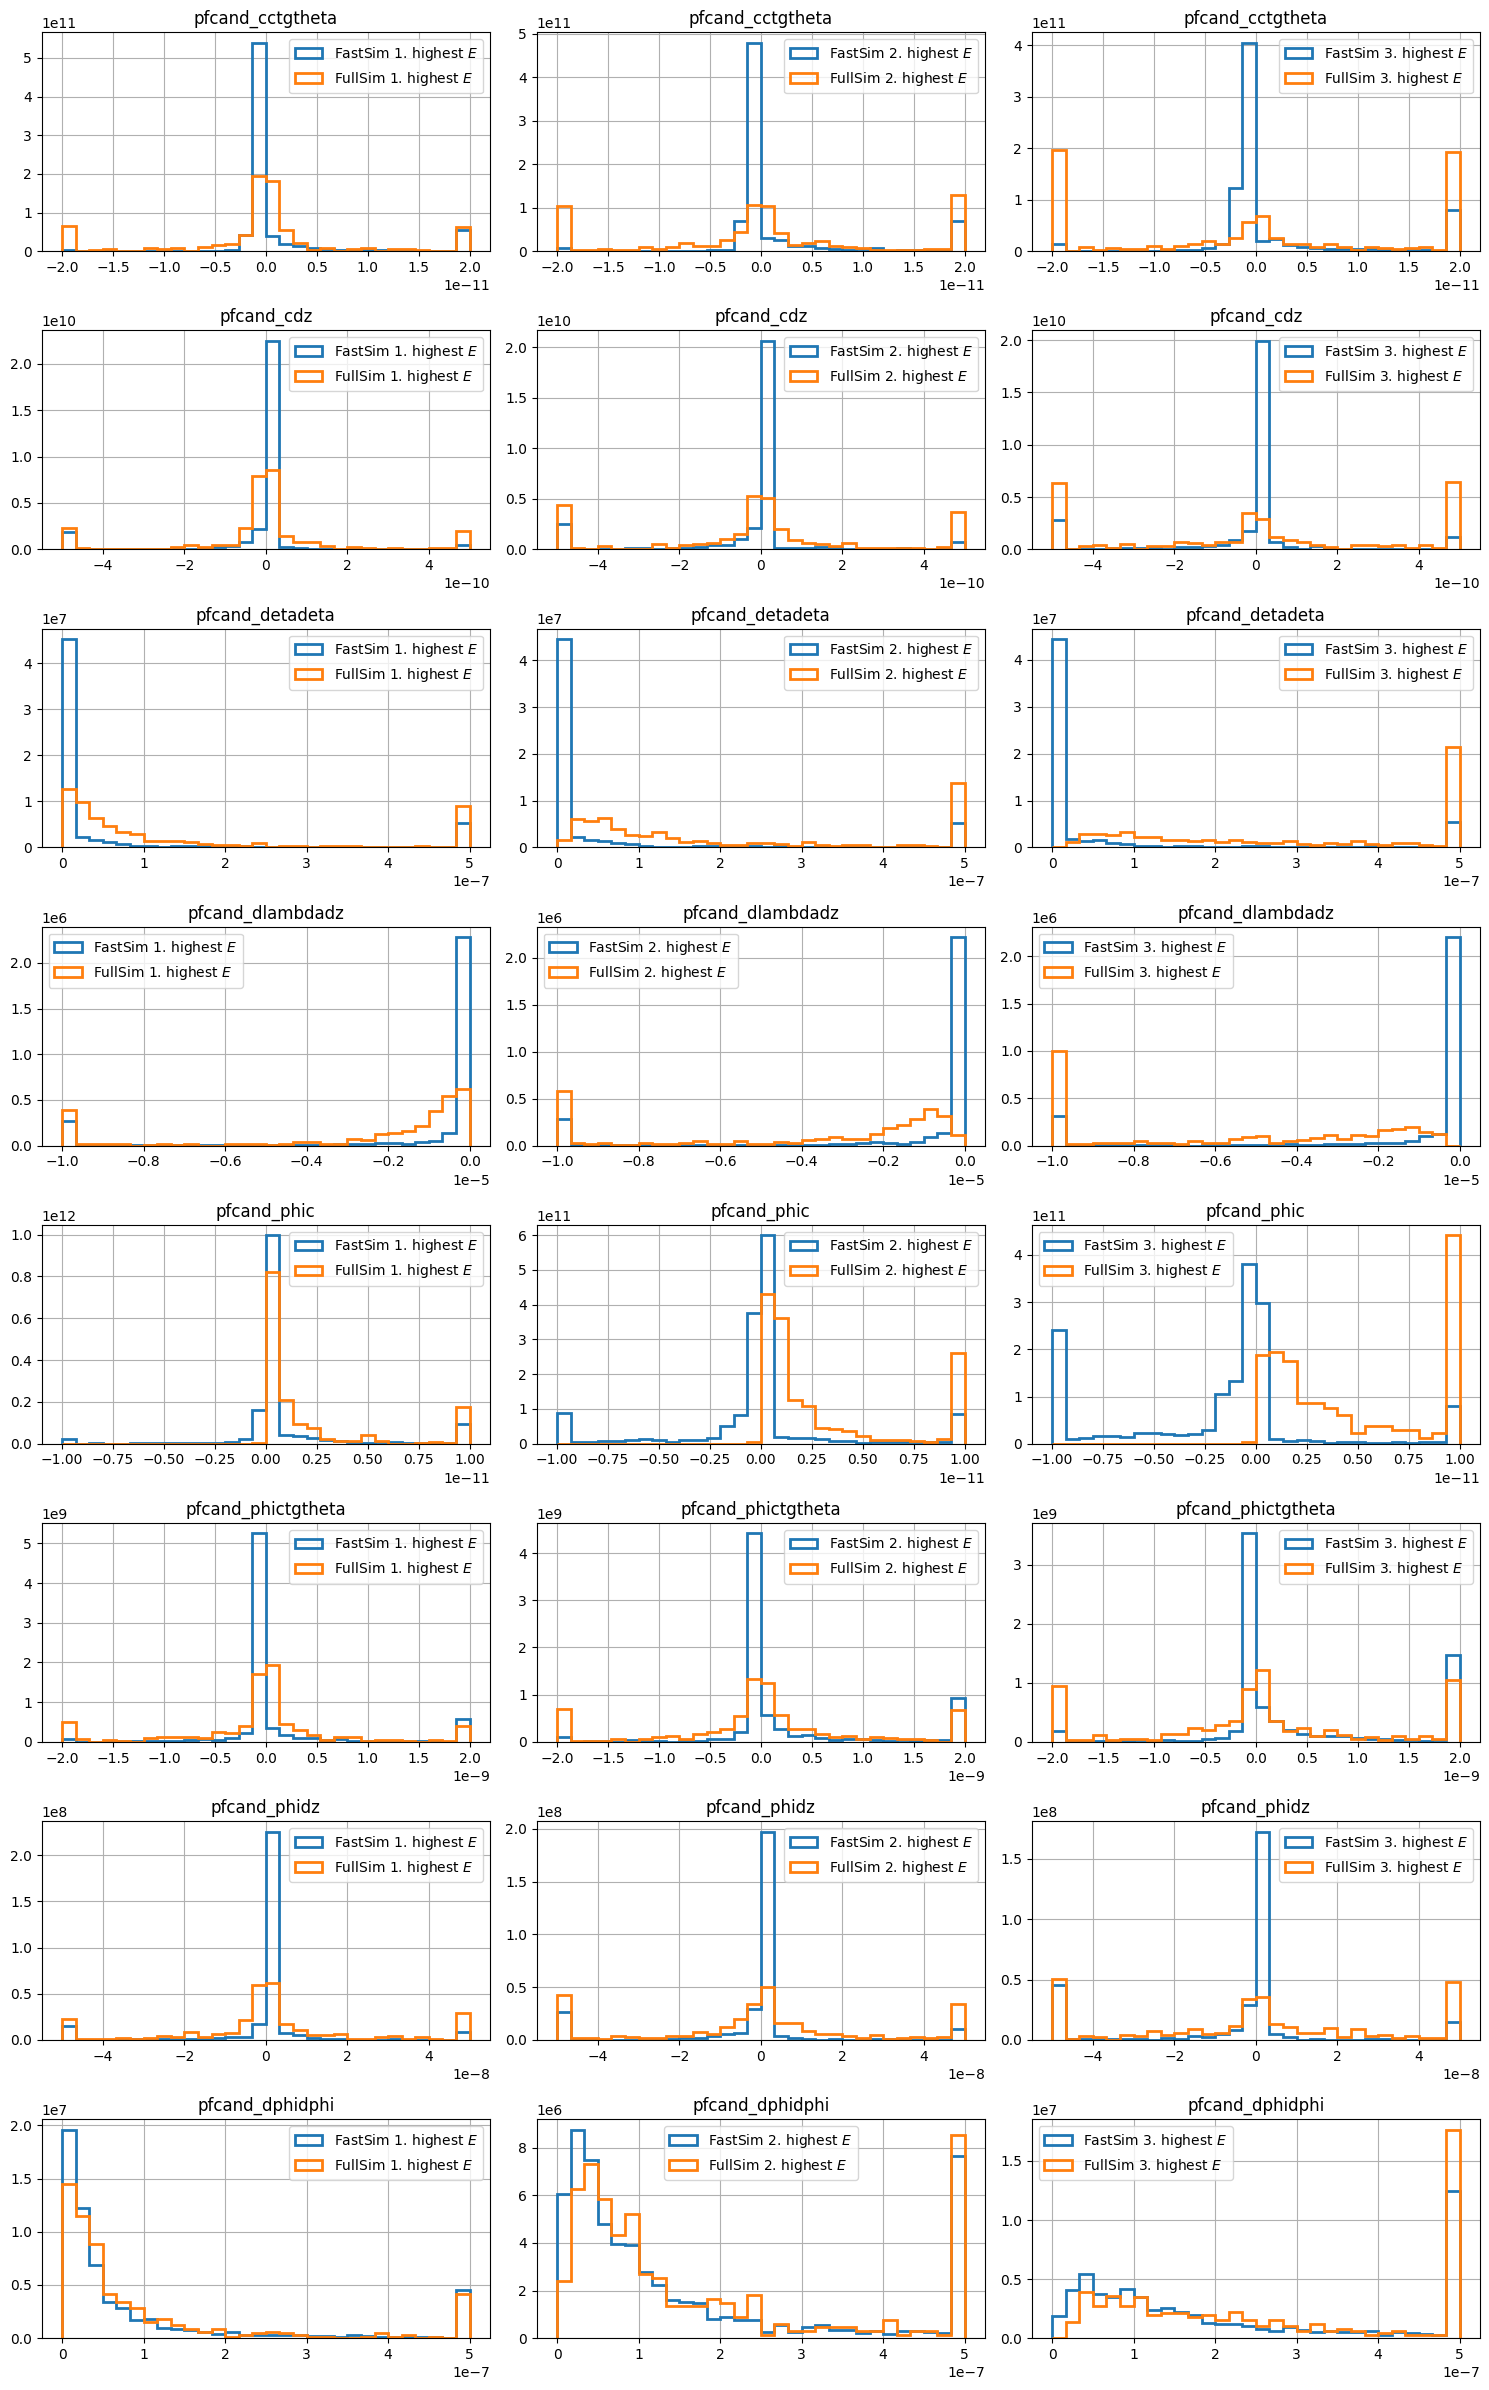

In [34]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi']

ranges = {
    'pfcand_cctgtheta': [-0.2e-10, 0.2e-10],
    'pfcand_cdz': [-0.5e-09, 0.5e-09],
    'pfcand_detadeta': [0, 0.5e-6],
    'pfcand_dlambdadz': [-1e-5, 0],
    'pfcand_phic': [-0.1e-10, 0.1e-10],
    'pfcand_phictgtheta': [-0.2e-08, 0.2e-08], 
    'pfcand_phidz': [-0.05e-6, 0.05e-6],
    'pfcand_dphidphi': [0.0, 0.5e-6]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_cov1.pdf')

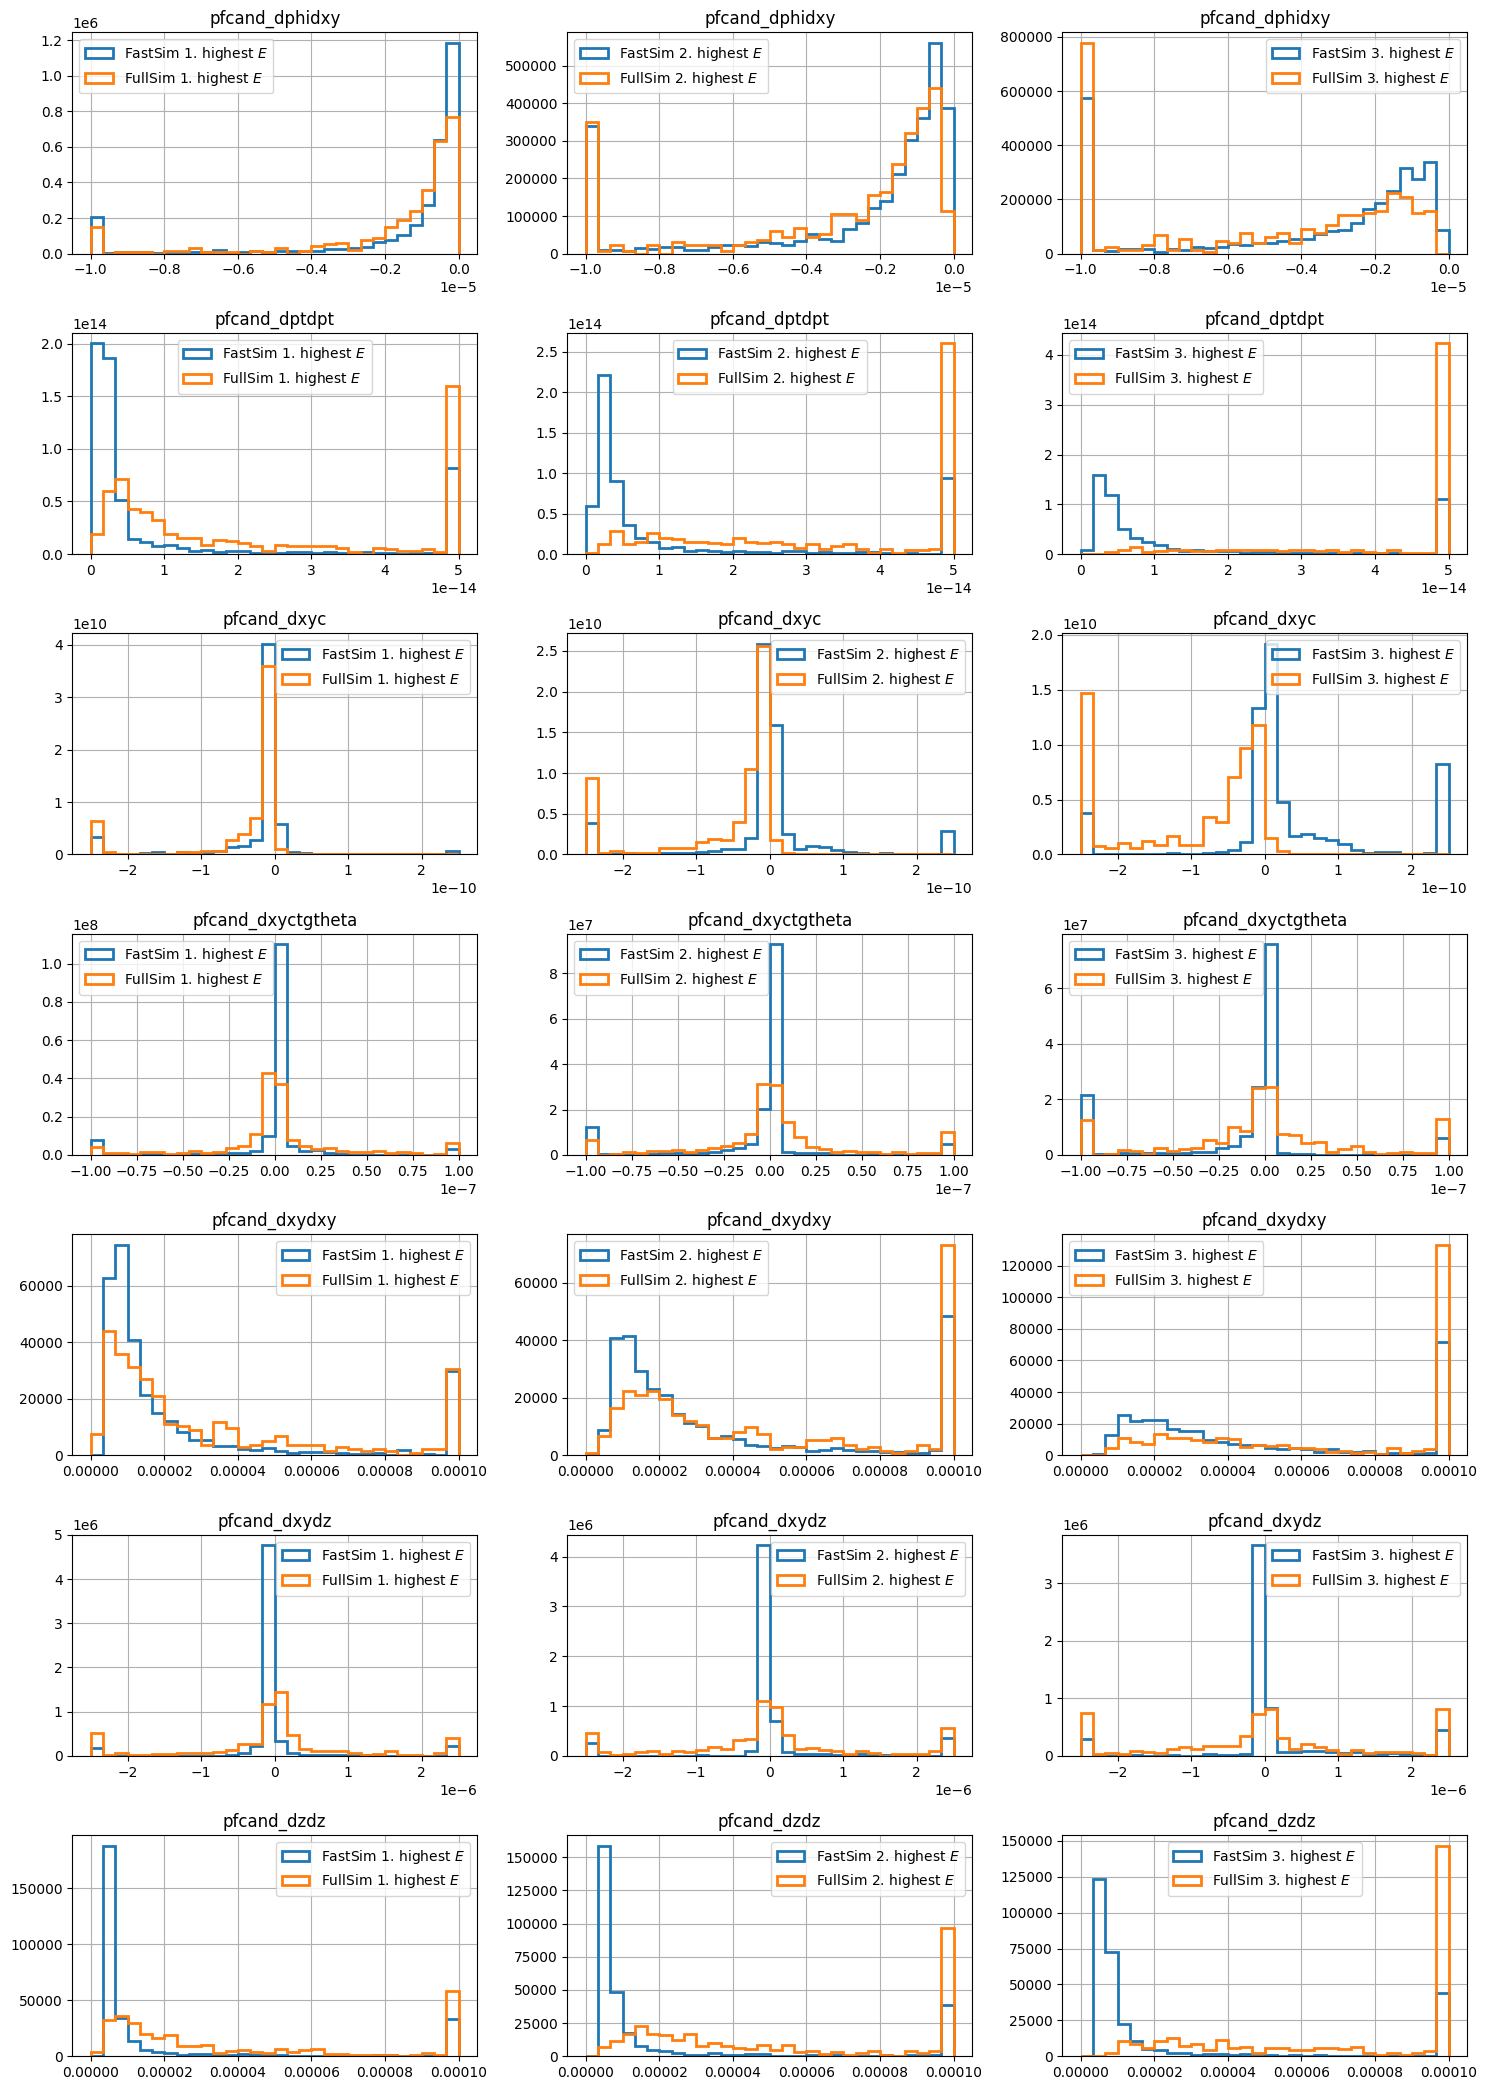

In [35]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dzdz']

ranges = {
    'pfcand_dphidxy': [-1e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 1e-4],
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_cov2.pdf')

Like above

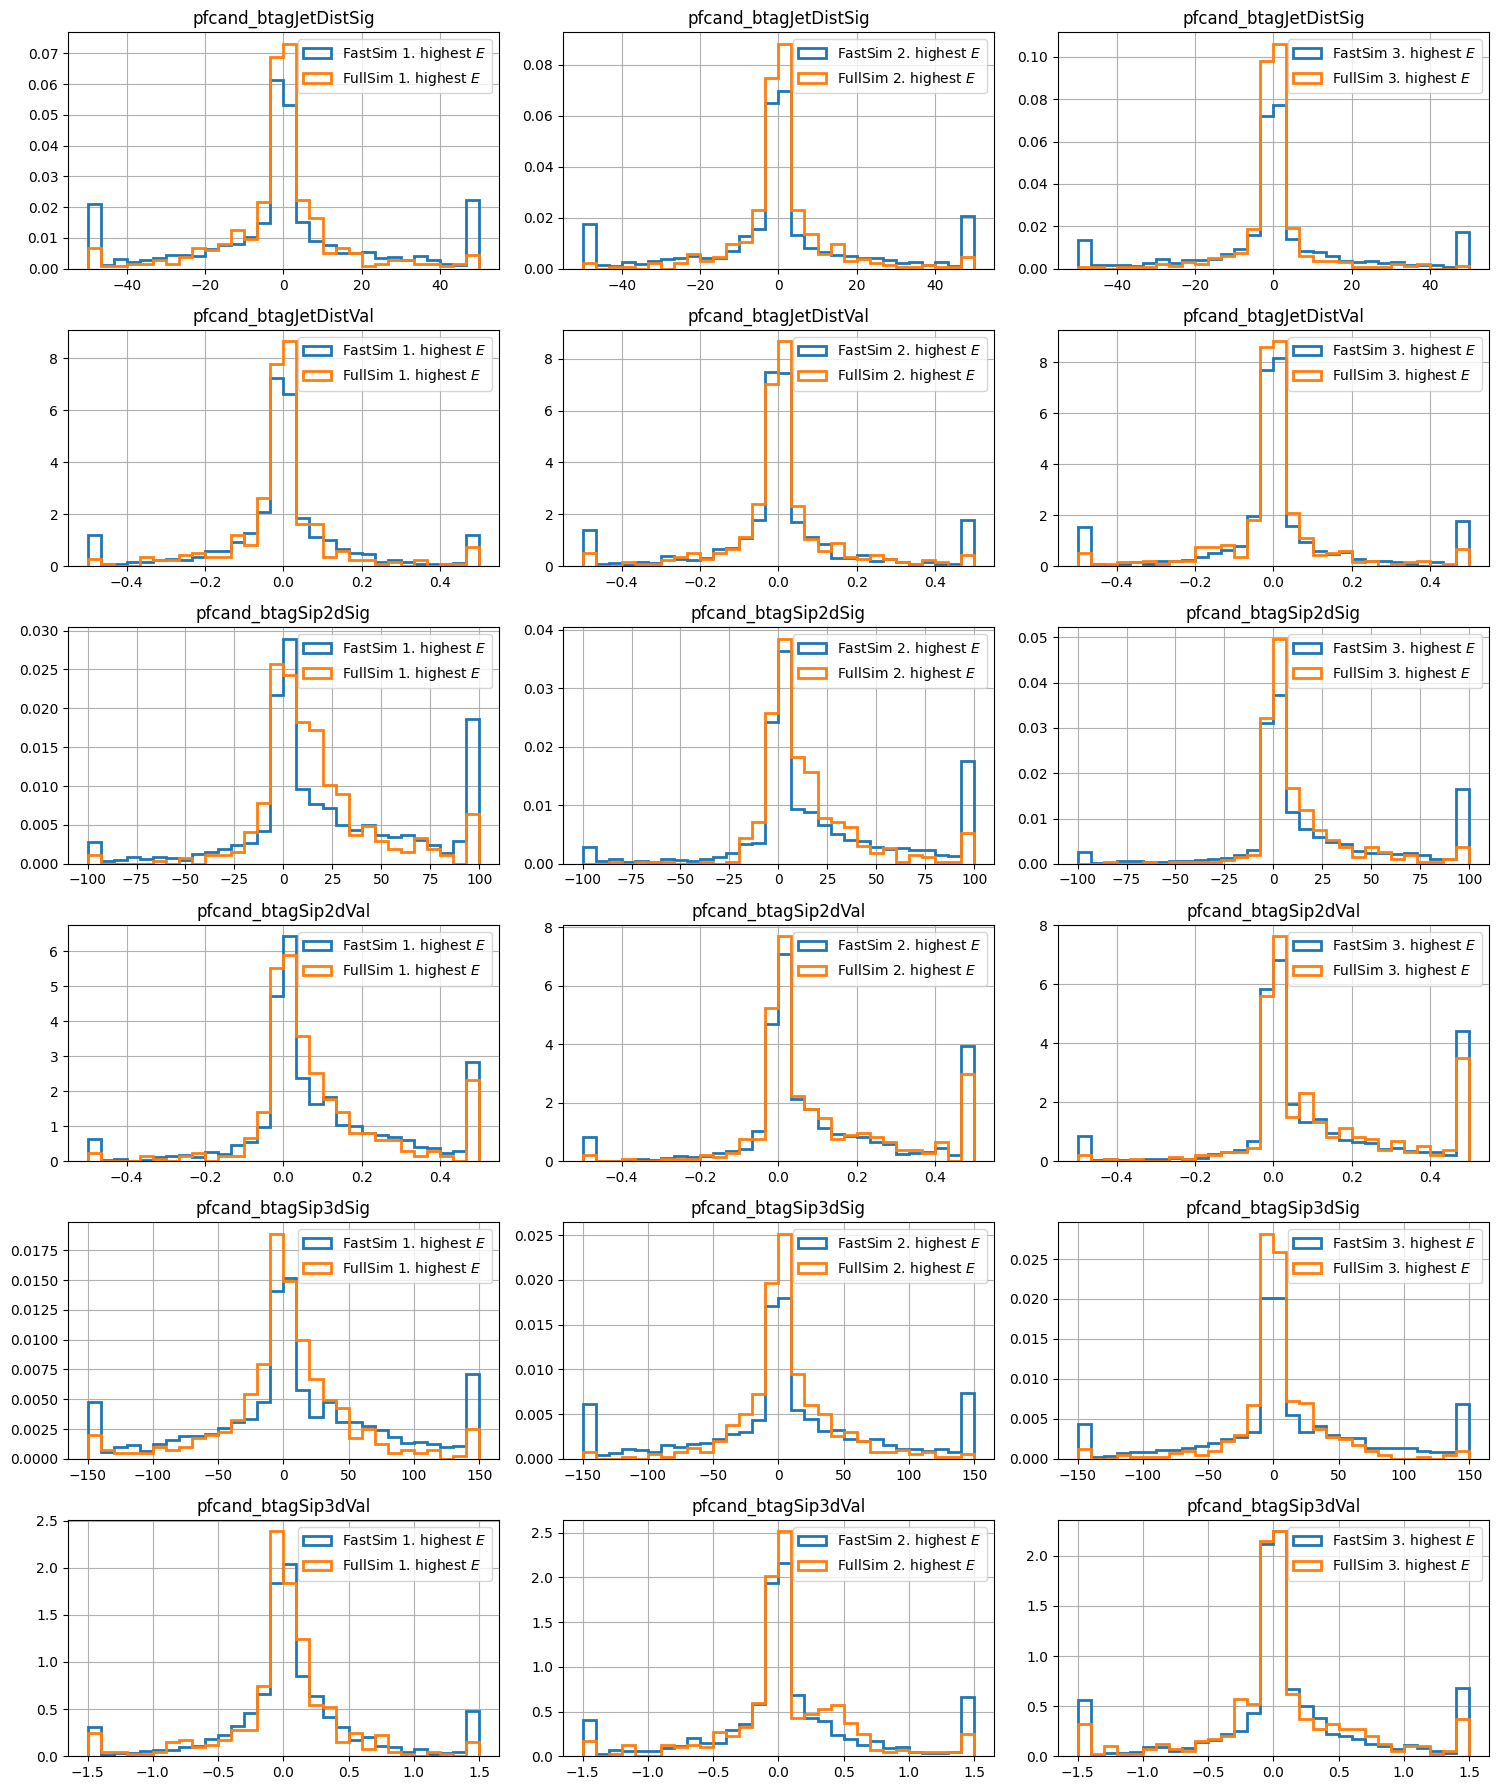

In [36]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

ranges = {
    'pfcand_btagJetDistSig': [-50, 50],
    'pfcand_btagJetDistVal': [-0.5, 0.5],
    'pfcand_btagSip2dSig': [-100, 100],
    'pfcand_btagSip2dVal': [-0.5, 0.5],
    'pfcand_btagSip3dSig': [-150, 150],
    'pfcand_btagSip3dVal': [-1.5, 1.5]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist/jetct_cp_dist.pdf')

## Alright: Now neutral particles!

In [37]:
def plot_key_highest_e_npart(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_neutral_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_neutral_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

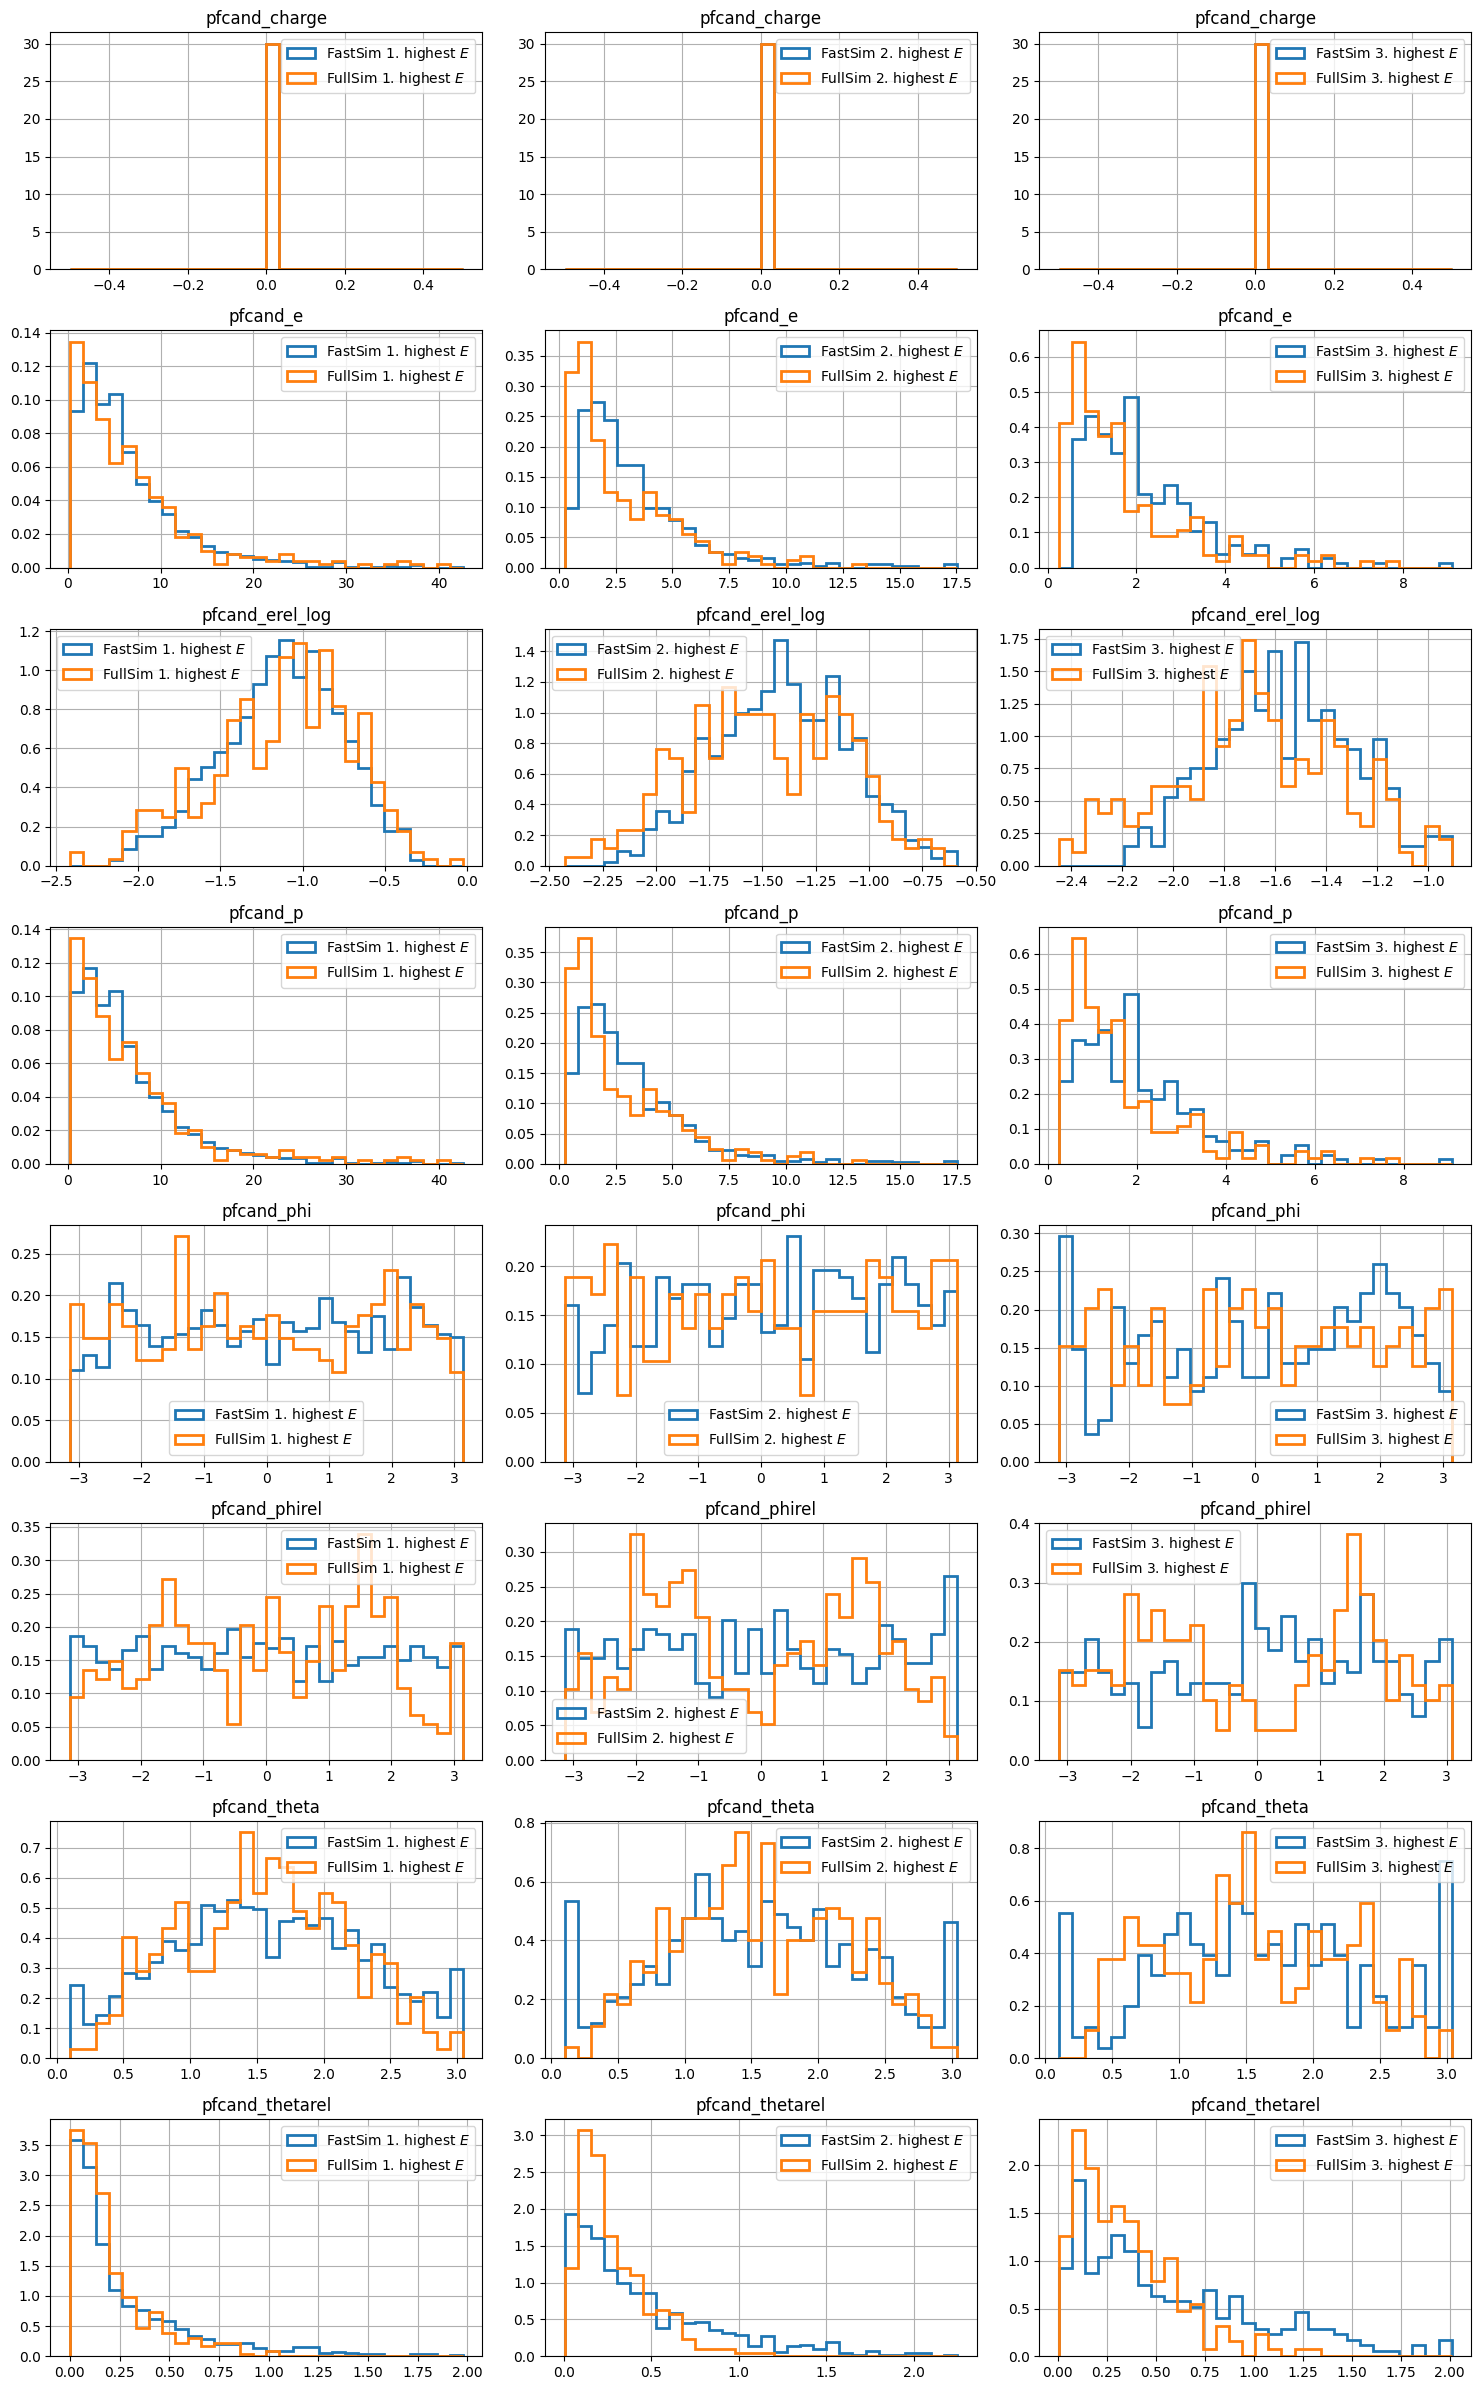

In [38]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_npart(keys, bins=30, save=save_status, path='./hist/jetct_np_properties.pdf')

We see: less neutrons with small momenta & energy. Distributions look ok'isch?

# For completion: Photons

In [39]:
def plot_key_highest_e_photon(keys, k=3, r=None, bins=20, log=False, save=False, path=None):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        a_list = get_chad_elements(df_fa[key], index_photon_3E_fa)
        b_list = get_chad_elements(df_fu[key], index_photon_3E_fu)

        ri = r[key] if r != None else None
        for i in range(k):
            ax = axs[idx, i]
            
            a = a_list[i]
            b = b_list[i]

            if ri == None:
                combined_min = min(a.min(), b.min())
                combined_max = max(a.max(), b.max())
                combined_range = (combined_min, combined_max)
            else:
                combined_range = ri
                # make overflow bins
                a = np.clip(a, *combined_range)
                b = np.clip(b, *combined_range)
            
            ax.set_title(key)
            ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$', density=True)
            ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$', density=True)
            if log:
                ax.set_yscale('log')
            ax.legend()
            ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist/histogram.pdf'
        plt.savefig(path)
    plt.show()

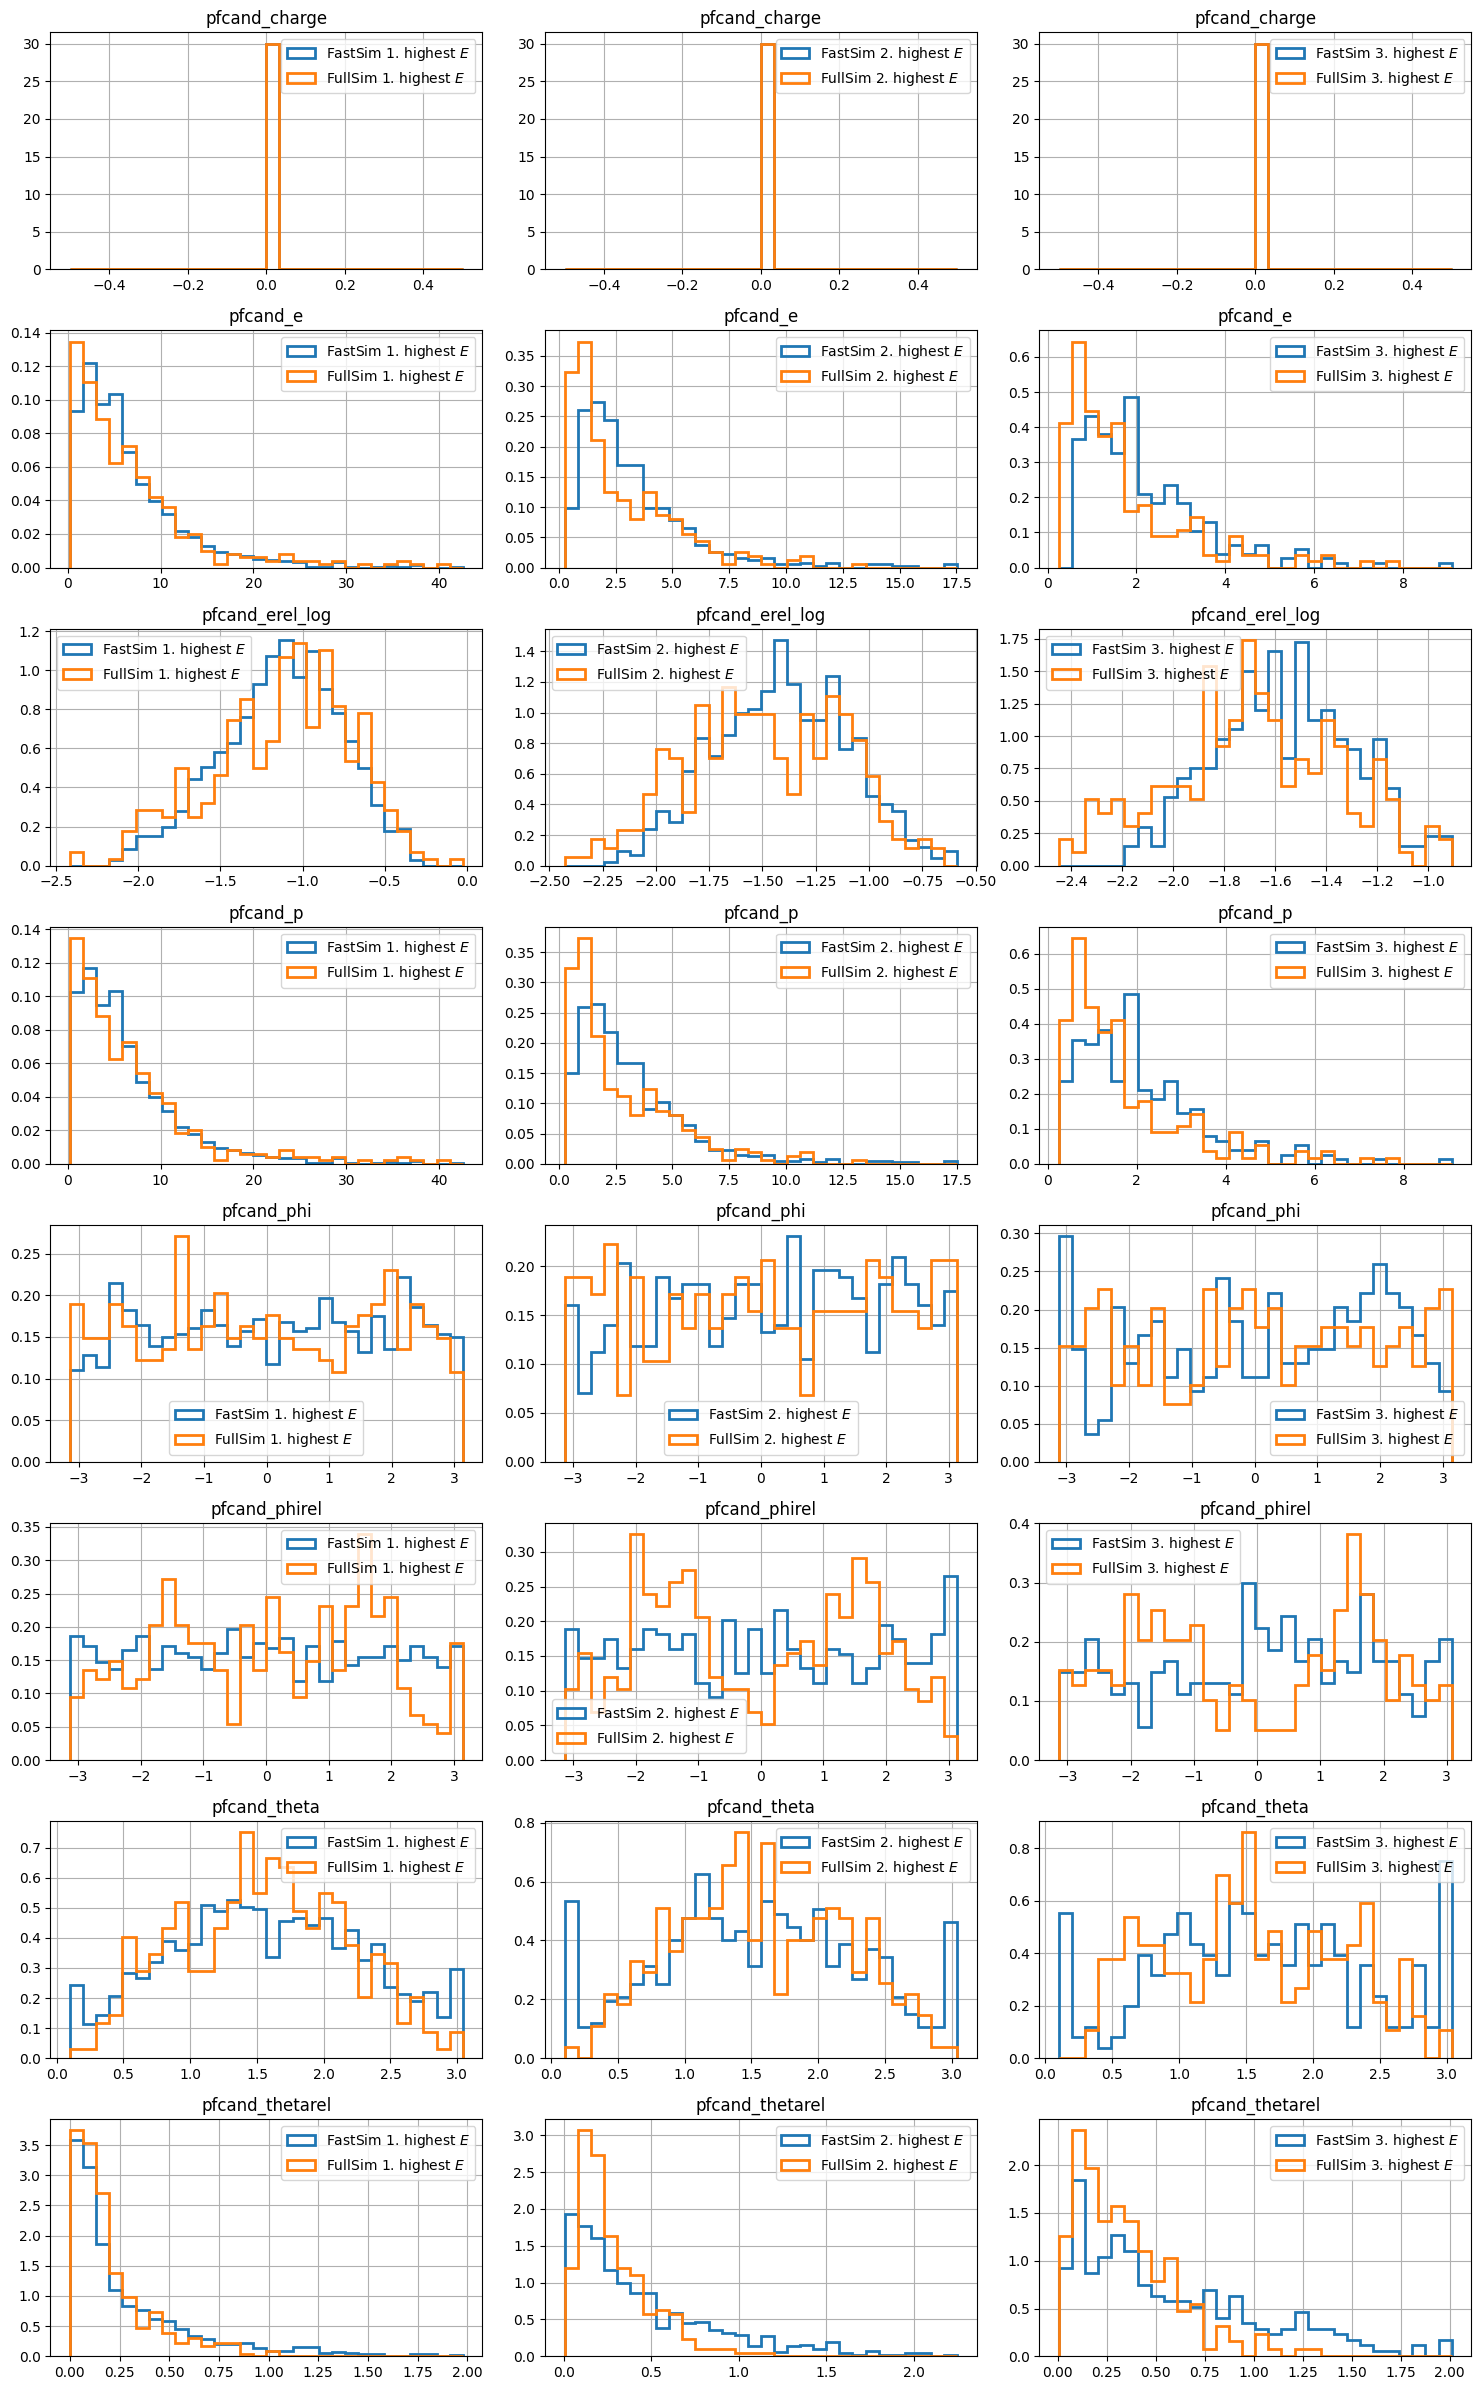

In [40]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_npart(keys, bins=30, save=save_status, path='./hist/jetct_gamma_properties.pdf')

In [41]:
print("hello")

hello
